In [2]:
import os
os.chdir(r'C:\Users\Administrator\LYC\SARMA\SARMA_code_share')

from main.BCD_LS import *
from main.BCD_MLE import *
from main.tensorOp import * 
from main.IOLS_VARMA import *
import main.help_function_for_LS as lsfunc
import main.help_function_for_MLE as mlfunc
from main.MACM import *
from main.BIC import *
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller



In [3]:
# import data
df = pd.read_csv("Application//FREDMD.csv",header=0, index_col=0)
df=df[['RPI','INDPRO','UNRATE','M2SL','CPIAUCSL','DPCERA3M086SBEA']]
df = df.drop(df.index[0])
df.index = pd.to_datetime(df.index)
df.head(5)
null_columns=df.isnull().any()

df = df[:-4]

# seasonally and stationally adjusted
df['RPI'] = df['RPI'].diff()
df['INDPRO'] = np.log(df['INDPRO']).diff()
df['UNRATE'] = np.log(df['UNRATE']).diff()
df['M2SL'] = np.log(df['M2SL']).diff().diff()
df['CPIAUCSL'] = np.log(df['CPIAUCSL']).diff().diff()
df['DPCERA3M086SBEA'] = np.log(df['DPCERA3M086SBEA']).diff()
df.dropna(inplace=True)

In [4]:
# standardized
df_norm = (df-df.mean())/df.std()

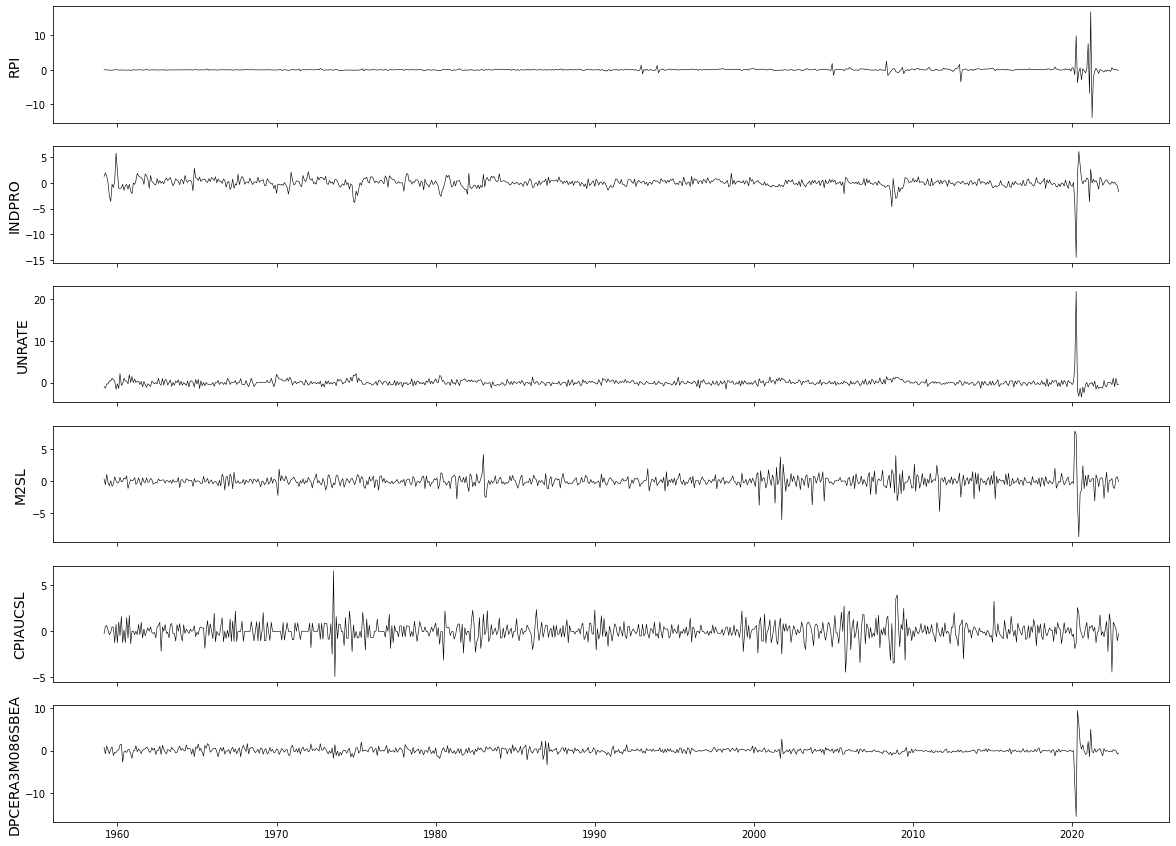

In [5]:
T,N = df_norm.shape
# plot
fig, axes = plt.subplots(nrows=N, ncols=1, sharex=True, figsize=(20, 15))
for idx, col in enumerate(df.columns):
    axes[idx].plot(df_norm[col],color='black',lw=0.6)
    axes[idx].set_ylabel(col,fontsize=14)
plt.show()


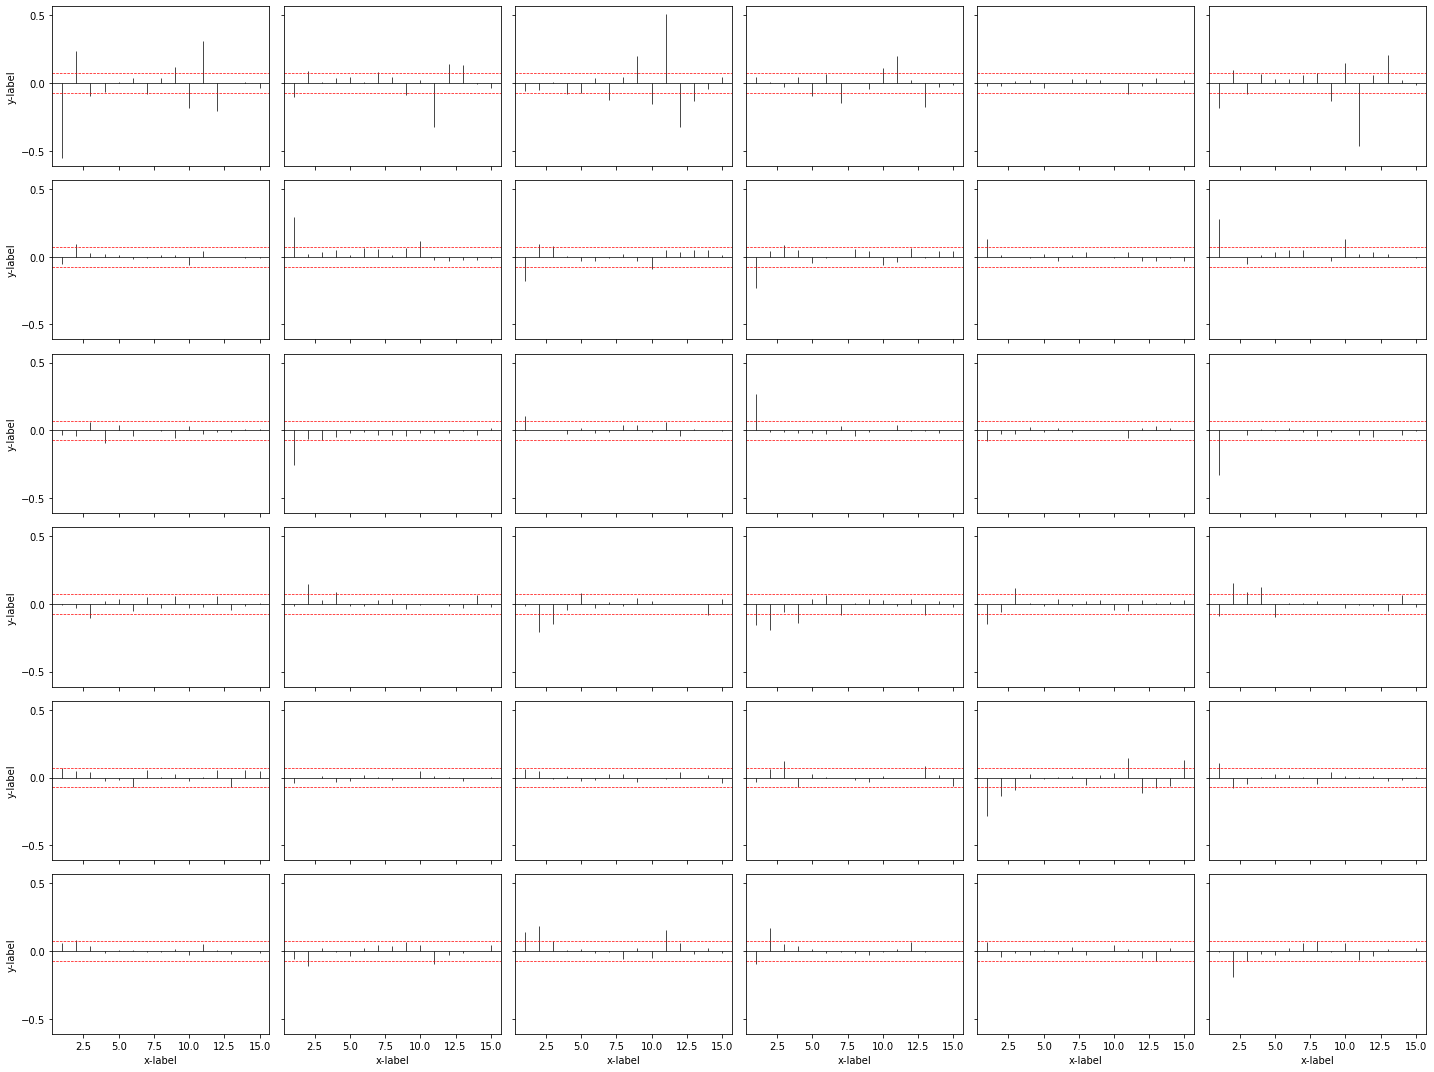

In [6]:

MACM_y=MACM(df_norm.values,15)
lag=16
err_bound = 2 / np.sqrt(T)
xlabel_lags=np.arange(1,lag)

fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(20, 15), sharex='all', sharey='all')
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.vlines(xlabel_lags, [0], MACM_y[:,i,j] ,color='k',linewidth=0.7)
        ax.axhline(0, color='k',linewidth=0.7)
        ax.axhline(err_bound, color='r', linestyle='--',linewidth=0.7)
        ax.axhline(-err_bound, color='r', linestyle='--',linewidth=0.7)
        if i == 5: 
            ax.set_xlabel('x-label')
            # axs[i, j].set_xticks([-0.5, 0, 0.5])
        if j == 0:  
            ax.set_ylabel('y-label')
            ax.set_yticks(np.linspace(-0.5,0.5,3))
plt.tight_layout()
plt.savefig("MACM_realdate.png", bbox_inches='tight')
plt.show()

In [8]:
df=df_norm.values.T
N,T = df.shape
p_m =2; r_m = 2; s_m = 1
#BIC choose order
BIC_reuslt = BIC(df,p_m,r_m ,s_m )

0 0 0
0 0 1
0 0 1
0 1 0
0 1 0


In [ ]:
# selected order
p=0; r=1; s=0

In [ ]:
# LS estimation
P=20; n_iter=50
lmbd=[0.95];gamma=[];phi=[]
result_LS = BCD_LS(df,p,r,s,P,n_iter,lmbd=np.array(lmbd), gamma = np.array(gamma), phi = np.array(phi),stop_thres=1e-5,result_show=True)
LS_lmbd,LS_eta,LS_G,LS_A,LS_Sigma=result_LS[['lmbd','eta','G','A','Sigma']]
LS_gamma,LS_phi = LS_eta

In [ ]:
# QML estimation

lmbd=[0.95];gamma=[];phi=[]
result_ML = BCD_MLE(df,p,r,s,P,n_iter,lmbd=np.array(lmbd), gamma = np.array(gamma), phi = np.array(phi),stop_thres=1e-5,result_show=True)
ML_lmbd,ML_eta,ML_G,ML_A,ML_Sigma=result_ML[['lmbd','eta','G','A','Sigma']]

In [ ]:
# forecast function for SARMA

def for_SARMA(y_train, y_test, lmbd,gamma,phi, G, h=1,estimation = "LS", method = 'rolling'):
    '''
    h: h-step forecast;
    method: rolling--fix window;
            recursive--fix start point
    -----------------------------------
    output:
    N*[length(y_test)-h+1]
    '''
    N,T_train = y_train.shape
    T_test = y_test.shape[1]
    y_oos = np.zeros((N,T_test-h+1)) ## save forecasts

    for t in range(T_test-h+1):
        if method == "rolling":
            y = np.hstack((y_train[:,t:], y_test[:,:t])) 
        elif method  == "recursive":
            y = np.hstack((y_train[:,:], y_test[:,:t])) 
        if estimation == "LSE":
            fit = BCD_LS(y,p,r,s,P,n_iter,lmbd=np.array(lmbd), gamma = np.array([gamma]), phi = np.array([phi]),G = G,result_show=False)
        if estimation == "MLE":
            fit = BCD_MLE(y,p,r,s,P,n_iter,lmbd=np.array(lmbd), gamma = np.array([gamma]), phi = np.array([phi]),G = G,result_show=False)
        lmbd = fit['lmbd']
        gamma,phi = fit['eta']
        G = fit['G']
        y_oos[:,t] = forecast_SARMA(y,p,r,s,lmbd,gamma,phi, G, h=h)[:,-1]
        
    return y_oos

In [ ]:
# forecast function for VAR_LS

def for_VAR(y_train, y_test ,h=1,order= (1,1), method = 'rolling'):
    N,T_train = y_train.shape
    T_test = y_test.shape[1]
    y_oos = np.zeros((N,T_test-h+1)) ## save forecasts

    for t in range(T_test-h+1):
        if method == "rolling":
            y = np.hstack((y_train[:,t:], y_test[:,:t])) 
        elif method  == "recursive":
            y = np.hstack((y_train[:,:], y_test[:,:t])) 
        model = VAR(y.T)
        results = model.fit(2)
        y_oos[:,t]= results.forecast(y.T[-2:],steps=1)
    return y_oos

forcast_VAR = for_VAR(y_train, y_test, h=1,order = (1,1) ,method = 'rolling')

In [ ]:
# forecast function for VARMA_IOLS

def for_IOLS_VARMA(y_train, y_test ,h=1, method = 'rolling'):
    N,T_train = y_train.shape
    T_test = y_test.shape[1]
    y_oos = np.zeros((N,T_test-h+1)) ## save forecasts

    for t in range(T_test-h+1):
        if method == "rolling":
            y = np.hstack((y_train[:,t:], y_test[:,:t])) 
        elif method  == "recursive":
            y = np.hstack((y_train[:,:], y_test[:,:t])) 
        y_oos[:,t]= IOLS_pre(y).ravel('F')
    return y_oos

In [ ]:
# forecast function for VARMA_QMLE
def for_VARMA(y_train, y_test ,h=1,order= (1,1), method = 'rolling'):
    N,T_train = y_train.shape
    T_test = y_test.shape[1]
    y_oos = np.zeros((N,T_test-h+1)) ## save forecasts

    for t in range(T_test-h+1):
        if method == "rolling":
            y = np.hstack((y_train[:,t:], y_test[:,:t])) 
        elif method  == "recursive":
            y = np.hstack((y_train[:,:], y_test[:,:t])) 
        model = VARMAX(y.T, order=(1,1))
        results = model.fit(maxiter= 20, disp=True)
        y_oos[:,t]= results.forecast(steps=1)
    return y_oos


In [ ]:
# forecasting setting
y_train =df[:,:600]
y_test=df[:,600:]
h=1 

# forecasst
forecast_SARMA_LS = for_SARMA(y_train, y_test, LS_lmbd,LS_gamma,LS_phi, LS_G, h=1,estimation = "LSE", method = 'rolling')
forecast_SARMA_QML = for_SARMA(y_train, y_test, ML_lmbd,ML_gamma,ML_phi, ML_G, h=1,estimation = "MLE", method = 'rolling')
forcast_VARMA_IOLS = for_IOLS_VARMA(y_train, y_test, h=1 ,method = 'rolling')
forecast_VAR_LS = for_VAR(y_train, y_test, h=1,order = (1,1) ,method = 'rolling')
forcast_VARMA_QML = for_VARMA(y_train, y_test, h=1,order = (1,1) ,method = 'rolling')

In [ ]:
SFE_table = pd.DataFrame(columns = ['SARMA_LS', 'SARMA_QML','VAR_LS', 'VARMA_IOLS','VARMA_QML'])
SAE_table = pd.DataFrame(columns = ['SARMA_LS', 'SARMA_QML','VAR_LS', 'VARMA_IOLS','VARMA_QML'])

SFE_table['SARMA_LS']= np.linalg.norm(forecast_SARMA_LS-y_test,ord= 2,axis=0)**2
SFE_table['QMLE']= np.linalg.norm(forecast_SARMA_QML-y_test,ord= 2,axis=0)**2
SFE_table['VAR_LS'] = np.linalg.norm(forcast_VAR-y_test,ord= 2,axis=0)**2
SFE_table['VARMA_IOLS'] = np.linalg.norm(forcast_VARMA_IOLS- y_test,ord=2,axis=0)**2
SFE_table['VARMA_QML'] = np.linalg.norm(forcast_VARMA_QML-y_test,ord= 2,axis=0)**2


SAE_table['SARMA_LS']= np.linalg.norm(forecast_SARMA_LS-y_test,ord= 1,axis=0)
SAE_table['QMLE']= np.linalg.norm(forecast_SARMA_QML-y_test,ord= 1,axis=0)
SAE_table['VAR_LS'] = np.linalg.norm(forcast_VAR-y_test,ord= 1,axis=0)
SAE_table['VARMA_IOLS'] = np.linalg.norm(forcast_VARMA_IOLS- y_test,ord=1,axis=0)
SAE_table['VARMA_QML'] = np.linalg.norm(forcast_VARMA_QML-y_test,ord= 1,axis=0)

# rooted mean squared forecast error
RMSFE = np.sqrt(SFE_table.mean())

# mean absoluted forecast error
MAFE = SAE_table.mean()